# Analysis of Alt-text use in mastodon.social by client

A project by [Cristal Rivera](https://linkedin.com/in/cristal-rivera-picado/) and [Tommaso Marmo](https://tommi.space/) to analyse the use of alt-text in [mastodon.social](https://mastodon.social/about), using [Stefan Bohacek](https://stefanbohacek.com/)’s <cite>[mastodon.social alt text use by client app](https://www.kaggle.com/datasets/fourtonfish/mastodon-social-alt-text-use-by-client-app)</cite> dataset, published on Kaggle under the [MIT license](https://www.mit.edu/~amini/LICENSE.md).

This analysis is being conducted as a group project for the [Introduction to Data Science](https://ois2.tlu.ee/tluois/subject/ULP6613-23265) course of the <cite>[Artificial Intelligence and Sustainable Societies](https://aissprogram.eu)</cite> master.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Import and print dataset
data = pd.read_csv('./fediverse-client-alt-text-data-2024-05-13.csv')
data

,client,status_count,descriptions_all_count,descriptions_all_percent,descriptions_some_count,descriptions_some_percent,descriptions_none_count,descriptions_none_percent
0,Web,8272,1438,17.383946,7,0.084623,6827,82.531431
1,dlvr.it,5806,1,0.017224,0,0.000000,5805,99.982776
2,Mastodon for Android,1894,270,14.255544,3,0.158395,1621,85.586061
3,unknown,1428,366,25.630252,1,0.070028,1061,74.299720
4,AboveMaidstoneBot,1339,0,0.000000,0,0.000000,1339,100.000000
...,...,...,...,...,...,...,...,...
261,socialbot,1,1,100.000000,0,0.000000,0,0.000000
262,PhonocasterMusicShare,1,0,0.000000,0,0.000000,1,100.000000
263,openvibe,1,0,0.000000,0,0.000000,1,100.000000
264,iflaapp,1,0,0.000000,0,0.000000,1,100.000000


## Data wrangling

In [3]:
#Cofirm the data type of the data set:
print(f'Confirm data type of the dataset: {type(data)}')

Confirm data type of the dataset: <class 'pandas.core.frame.DataFrame'>


In [4]:
# Experimental example taken from ChatGPT(this can be removed)
def summarize_dataframe(df):
    """
    Provides a summary of each column in the DataFrame, including:
    - Data type
    - Number of missing values
    - Number of unique values
    - Descriptive statistics (for numerical columns)
    
    Parameters:
    df (pd.DataFrame): The DataFrame to summarize.
    """
    # Data type and count of missing values
    summary = pd.DataFrame({
        'Data Type': df.dtypes,
        'Missing Values': df.isnull().sum(),
        'Unique Values': df.nunique()
    })
    
    # Descriptive statistics for numerical columns
    numerical_summary = df.describe().T
    summary = summary.merge(numerical_summary, left_index=True, right_index=True, how="left")
    
    # Display summary for categorical columns separately
    categorical_columns = df.select_dtypes(include=['object']).columns
    categorical_summary = df[categorical_columns].describe().T
    
    print("Summary of Numerical Columns:")
    display(summary)
    print("\nSummary of Categorical Columns:")
    display(categorical_summary)

summarize_dataframe(data)

Summary of Numerical Columns:


,Data Type,Missing Values,Unique Values,count,mean,std,min,25%,50%,75%,max
client,object,0,266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
status_count,int64,0,80,266.0,112.240602,643.625189,1.0,2.0,8.0,39.75,8272.000000
descriptions_all_count,int64,0,45,266.0,21.473684,105.282555,0.0,0.0,0.0,4.00,1438.000000
descriptions_all_percent,float64,0,44,266.0,36.290411,45.079671,0.0,0.0,0.0,100.00,100.000000
descriptions_some_count,int64,0,6,266.0,0.093985,0.622382,0.0,0.0,0.0,0.00,7.000000
descriptions_some_percent,float64,0,12,266.0,0.060461,0.527118,0.0,0.0,0.0,0.00,7.142857
descriptions_none_count,int64,0,70,266.0,90.672932,568.477040,0.0,0.0,2.0,20.00,6827.000000
descriptions_none_percent,float64,0,44,266.0,63.649128,45.113843,0.0,0.0,100.0,100.00,100.000000



Summary of Categorical Columns:


,count,unique,top,freq
client,266,266,Statuzer,1


In [5]:
#Describe the data set
data_stats = data.describe()

In [6]:
##add the mode in the describe function

#Get the mode for each column 
mode_values = data.mode().iloc[0] #iloc We use .iloc[0] to get the first mode (as mode() can return multiple values if there is more than one mode).

# Combine the two (mode and describe)
data_stats.loc['mode'] = mode_values

# Show the result
print(data_stats)

       status_count  descriptions_all_count  descriptions_all_percent  \
count    266.000000              266.000000                266.000000   
mean     112.240602               21.473684                 36.290411   
std      643.625189              105.282555                 45.079671   
min        1.000000                0.000000                  0.000000   
25%        2.000000                0.000000                  0.000000   
50%        8.000000                0.000000                  0.000000   
75%       39.750000                4.000000                100.000000   
max     8272.000000             1438.000000                100.000000   
mode       1.000000                0.000000                  0.000000   

       descriptions_some_count  descriptions_some_percent  \
count               266.000000                 266.000000   
mean                  0.093985                   0.060461   
std                   0.622382                   0.527118   
min                   0.0

### Information about the dataset

In [7]:
##Review shape of the dataset

# Tuple with number of rows and number of columns
data_rows, data_columns = data.shape
# Integer that is the result of n of columns * n of rows
data_size = data.size

print(f'Number of rows: {data_rows}\nNumber of columns: {data_columns}\nData size (rows*columns): {data_size}')

Number of rows: 266
Number of columns: 8
Data size (rows*columns): 2128


In [8]:
# Check if there are any duplicated clients
any(data.duplicated())

False

In [9]:
# Check if there are any missing values in status_count
any(data.status_count.isnull())

False

In [10]:
# Sort clients by status_count
data = data.sort_values('status_count',ascending=False)

### Naming and understanding data fields

All columns correspond to relevant data, and to achieve this we will be going through each column, one by one, to understand its meaning and rename it in more explicatory name.

In [11]:
data = data.rename(columns={
    'status_count': 'posts_count',
    'descriptions_all_count': 'alttext_all_count',
    'descriptions_all_percent': 'alttext_all_percent',
    'descriptions_some_count': 'alttext_some_count',
    'descriptions_some_percent': 'alttext_some_percent',
    'descriptions_none_count': 'alttext_none_count',
    'descriptions_none_percent': 'alttext_none_percent'
})

## Data exploration

In [12]:
data.head()

,client,posts_count,alttext_all_count,alttext_all_percent,alttext_some_count,alttext_some_percent,alttext_none_count,alttext_none_percent
0,Web,8272,1438,17.383946,7,0.084623,6827,82.531431
1,dlvr.it,5806,1,0.017224,0,0.000000,5805,99.982776
2,Mastodon for Android,1894,270,14.255544,3,0.158395,1621,85.586061
3,unknown,1428,366,25.630252,1,0.070028,1061,74.299720
4,AboveMaidstoneBot,1339,0,0.000000,0,0.000000,1339,100.000000


In [13]:
data.tail()

,client,posts_count,alttext_all_count,alttext_all_percent,alttext_some_count,alttext_some_percent,alttext_none_count,alttext_none_percent
234,pycasso,1,1,100.0,0,0.0,0,0.0
235,fsposter a4n,1,0,0.0,0,0.0,1,100.0
236,TweeseCake,1,1,100.0,0,0.0,0,0.0
237,AutstralianArtGallery_clientcred.secret,1,1,100.0,0,0.0,0,0.0
265,Today's Dérive app task,1,1,100.0,0,0.0,0,0.0


In [14]:
posts_count_total = data['posts_count'].sum()
alttext_all_count_total = data['alttext_all_count'].sum()
alttext_some_count_total = data['alttext_some_count'].sum()
alttext_none_count_total = data['alttext_none_count'].sum()

alttext_all_count_total_pct = round(alttext_all_count_total / posts_count_total * 100, 2)
alttext_some_count_total_pct = round(alttext_some_count_total / posts_count_total * 100, 2)
alttext_none_count_total_pct = round(alttext_none_count_total / posts_count_total * 100, 2)

if posts_count_total == alttext_all_count_total + alttext_some_count_total + alttext_none_count_total:
    print('Posts count is matching!')
else:
    print('Something is wrong in the dataset. Please revise the number of posts!')

print(f"""
Total number of posts under analysis: {posts_count_total}
    of which {alttext_all_count_total} ({alttext_all_count_total_pct}%) contain an alt-text for all images,
    {alttext_some_count_total} ({alttext_some_count_total_pct}%) for some,
    and {alttext_none_count_total} ({alttext_none_count_total_pct}%) have no alt-text at all.
""")

Posts count is matching!

Total number of posts under analysis: 29856
    of which 5712 (19.13%) contain an alt-text for all images,
    25 (0.08%) for some,
    and 24119 (80.78%) have no alt-text at all.



([<matplotlib.patches.Wedge at 0x24055827250>,
 [Text(0.9072200784388501, 0.6220544423741436, 'Alt-text for all'),
  Text(0.39375082293551933, 1.0271125982274785, 'Alt-text for some'),
  Text(-0.9055804996477597, -0.6244389150731353, 'No alt-text')],
 [Text(0.4948473155121, 0.3393024231131692, '19.1%'),
  Text(0.21477317614664687, 0.5602432353968063, '0.1%'),
  Text(-0.49395299980786883, -0.34060304458534646, '80.8%')])

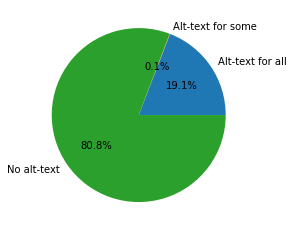

In [15]:
posts_pie = [alttext_all_count_total, alttext_some_count_total, alttext_none_count_total]
labels_pie = ['Alt-text for all', 'Alt-text for some', 'No alt-text']

fig, ax = plt.subplots()
ax.pie(posts_pie, labels=labels_pie, autopct='%1.1f%%')

In this section, we will analyze the total number of posts per client. During the initial data exploration, we observed that many clients have only one post. Our objective is to explore how many clients fall into this category and determine whether it would be beneficial to treat this group differently to reduce potential noise in the dataset.

In [16]:
##Count how many posts_counts by client

#select columns we want to analyze
data_selected = data[['client', 'posts_count']].head(20) # take only the first 20 clients to have a general overview on how they behave
data_selected


,client,posts_count
0,Web,8272
1,dlvr.it,5806
2,Mastodon for Android,1894
3,unknown,1428
4,AboveMaidstoneBot,1339
5,Mastodon for iOS,1052
6,Buffer,795
7,Indie 102.3 Playlist Bot,571
8,Tusky,509
9,KUVO Playlist Bot,365


<module 'matplotlib.pyplot' from 'C:\\Users\\crist\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

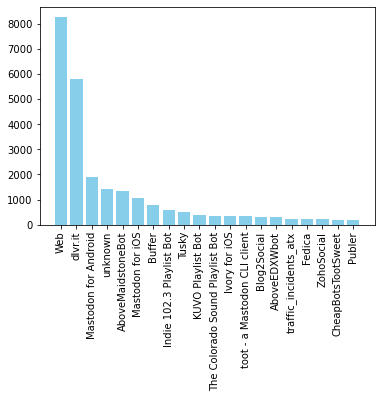

In [17]:
#barplot: to review top 20 clients with more posts
plt.bar(data_selected['client'],data_selected['posts_count'],color = 'skyblue')
plt.xticks(rotation=90)
plt

The bar plot reveals that among the top 20 clients, Client Web has the highest number of posts, with 8,272, while Publer has only 192 posts. This highlights a significant disparity in the number of posts even within the top 20 clients, showcasing the wide variation in engagement levels between the extremes.

In [18]:
# we want to know how many clients from the 266 clients have only one post, we will filter the data where posts_count=1
data_post_1 = data[data['posts_count'] == 1]
data_post_1

,client,posts_count,alttext_all_count,alttext_all_percent,alttext_some_count,alttext_some_percent,alttext_none_count,alttext_none_percent
250,Wabi Wabi pictures,1,0,0.0,0,0.0,1,100.0
249,madonctl,1,0,0.0,0,0.0,1,100.0
248,yongchieng,1,0,0.0,0,0.0,1,100.0
247,Bridgy,1,0,0.0,0,0.0,1,100.0
244,Grafa Page Manager,1,1,100.0,0,0.0,0,0.0
246,Daily Loss Bot,1,0,0.0,0,0.0,1,100.0
245,Github Action,1,1,100.0,0,0.0,0,0.0
243,Mastoot,1,0,0.0,0,0.0,1,100.0
242,AEGIS FS Poster App,1,0,0.0,0,0.0,1,100.0
252,Unsplash Daily Image,1,0,0.0,0,0.0,1,100.0


In [19]:
#count how many clients have only one post
len_post_1 = len(data_post_1) #is 52, meaning that 52 are the clients with one post
len(data) # 266 from original data set


#proportion 
prop_1 = (len_post_1/len(data))*100
prop_1

19.548872180451127

Around 19% of the clients in the data set have only one post

In [20]:
# Now comparing this with the entire data set:In general we want to count how many clients have each number of posts
# Count how many clients have each number of posts
post_counts = data['posts_count'].value_counts().sort_index()
post_counts

1       52
2       31
3       18
4       14
5        7
        ..
1339     1
1428     1
1894     1
5806     1
8272     1
Name: posts_count, Length: 80, dtype: int64

The `posts_count` analysis groups the number of posts and counts how many clients fall into each group. For example, there are 52 clients with only one post, 31 clients with two posts, and so on. This distribution clearly indicates that a significant portion of clients have only one post. Such a notable concentration suggests it might be more meaningful to treat these single-post clients as a separate cluster and analyze them independently to reduce potential noise in the dataset and gain more targeted insights.


Text(0.5, 1.0, 'Frequency of total posts counted by client')

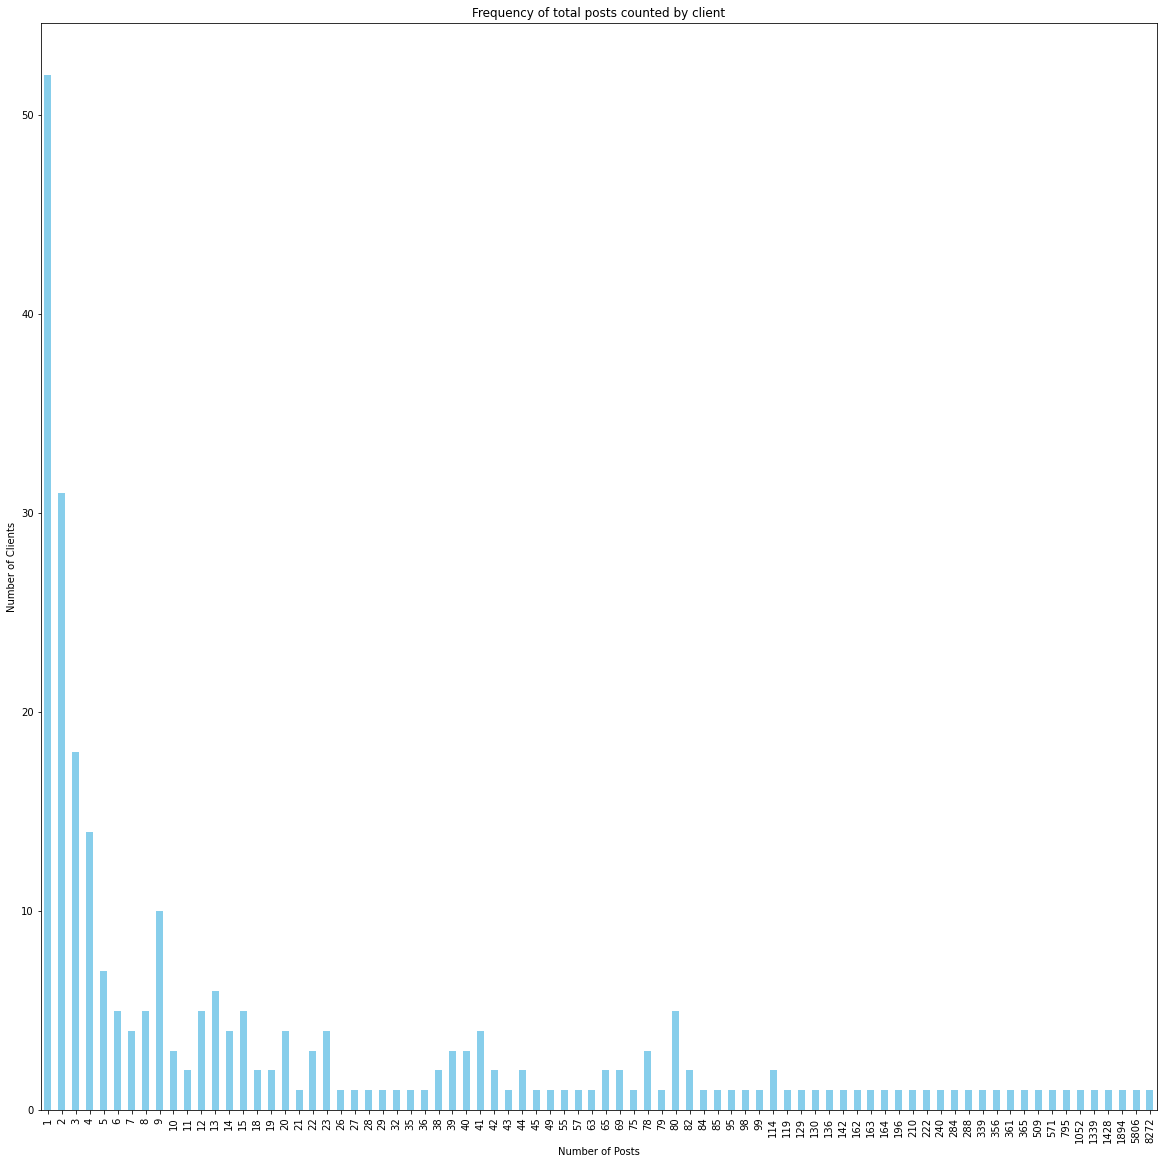

In [21]:
# Create a bar plot
plt.figure(figsize=(20, 20))
post_counts.plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel("Number of Posts")
plt.ylabel("Number of Clients")
plt.title("Frequency of total posts counted by client")

Text(0.5, 1.0, 'Frequency of total posts counted by client')

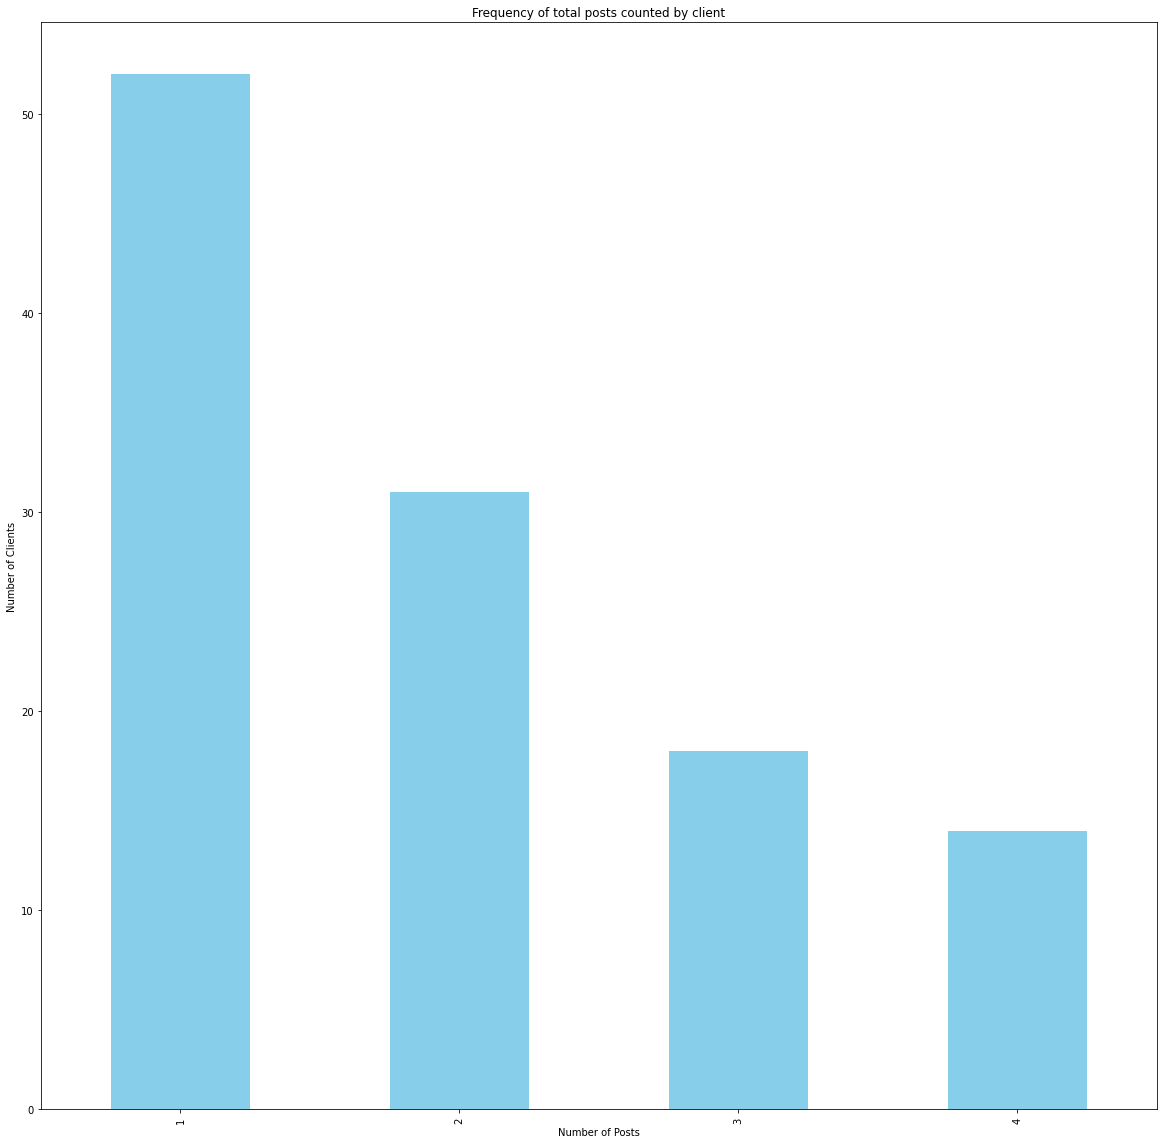

In [22]:
## Let's take a closer look : Filter out post counts with less than 4 posts, based on the data it still be a higher number of clients for those.
post_counts = post_counts[(post_counts.index >= 1) & (post_counts.index <= 4)]

# Ensure the values are numeric
post_counts.astype(int)

# Create a bar plot
plt.figure(figsize=(20, 20))
post_counts.plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel("Number of Posts")
plt.ylabel("Number of Clients")
plt.title("Frequency of total posts counted by client")

Clients that have more than 4 postsThe previous graphs highlights that the majority of clients in the dataset have either one or two posts. This behavior suggests a distinct pattern that warrants separate analysis for these clients. To better understand their impact and characteristics, we will proceed by dividing the dataset into two groups: one consisting of clients with one or two posts, and the other including all remaining clients. This approach will allow for a more focused and meaningful analysis of each group.

### Clients that have more than 4 posts

In [62]:
#Separate data set by excluding 52 clients with only one post

cl_more_post = data[data['posts_count'] > 4]
len(cl_more_post)

151

In [24]:
type(cl_more_post)

pandas.core.frame.DataFrame

In [25]:
#Review statistics
cl_more_post.describe()

,posts_count,alttext_all_count,alttext_all_percent,alttext_some_count,alttext_some_percent,alttext_none_count,alttext_none_percent
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,196.238411,37.185430,33.741165,0.165563,0.106508,158.887417,66.152327
std,845.823872,137.864349,42.984273,0.820004,0.697091,748.392326,43.053854
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,1.000000,1.020408,0.000000,0.000000,15.000000,98.979592
75%,80.000000,18.000000,100.000000,0.000000,0.000000,61.000000,100.000000
max,8272.000000,1438.000000,100.000000,7.000000,7.142857,6827.000000,100.000000


In [63]:
# this has to be at the beginning of the project
cl_more_post[cl_more_post['client'] != 'unknown']

,client,posts_count,alttext_all_count,alttext_all_percent,alttext_some_count,alttext_some_percent,alttext_none_count,alttext_none_percent
0,Web,8272,1438,17.383946,7,0.084623,6827,82.531431
1,dlvr.it,5806,1,0.017224,0,0.000000,5805,99.982776
2,Mastodon for Android,1894,270,14.255544,3,0.158395,1621,85.586061
4,AboveMaidstoneBot,1339,0,0.000000,0,0.000000,1339,100.000000
5,Mastodon for iOS,1052,227,21.577947,1,0.095057,824,78.326996
...,...,...,...,...,...,...,...,...
149,FediPlan,5,5,100.000000,0,0.000000,0,0.000000
146,SocialBu,5,0,0.000000,0,0.000000,5,100.000000
147,Postpone.app,5,0,0.000000,0,0.000000,5,100.000000
145,The Pink Zune,5,0,0.000000,0,0.000000,5,100.000000


In [64]:
# Sort the data frame from the clients that have highest counts of having alt text in their images.
cl_more_post_sort = cl_more_post.sort_values('alttext_all_percent', ascending=False)
cl_more_post_sort

,client,posts_count,alttext_all_count,alttext_all_percent,alttext_some_count,alttext_some_percent,alttext_none_count,alttext_none_percent
75,Anthologia Graeca,29,29,100.0,0,0.0,0,0.0
118,ActivityPub.jl,10,10,100.0,0,0.0,0,0.0
116,Anarchist Art,11,11,100.0,0,0.0,0,0.0
111,Bots.law,12,12,100.0,0,0.0,0,0.0
110,StorePageTooter,12,12,100.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...
94,Random Images,18,0,0.0,0,0.0,18,100.0
93,Leeralles.nl,18,0,0.0,0,0.0,18,100.0
31,Ukraine News bot,95,0,0.0,0,0.0,95,100.0
90,wikiRandomImgs_bot,20,0,0.0,0,0.0,20,100.0


In [65]:
#How many and which are the clients that have zero alt text in their images
clients_zero_alttext = cl_more_post[cl_more_post['alttext_none_percent'] == 0]
clients_zero_alttext

,client,posts_count,alttext_all_count,alttext_all_percent,alttext_some_count,alttext_some_percent,alttext_none_count,alttext_none_percent
7,Indie 102.3 Playlist Bot,571,571,100.0,0,0.0,0,0.0
9,KUVO Playlist Bot,365,365,100.0,0,0.0,0,0.0
10,The Colorado Sound Playlist Bot,361,361,100.0,0,0.0,0,0.0
28,TheMoscowTimesByNB,114,114,100.0,0,0.0,0,0.0
35,python bot,82,82,100.0,0,0.0,0,0.0
38,livelakemichigan,80,80,100.0,0,0.0,0,0.0
42,fediverse,78,78,100.0,0,0.0,0,0.0
52,Flame Reactor,55,55,100.0,0,0.0,0,0.0
54,startrekscreens,45,45,100.0,0,0.0,0,0.0
55,TheInsiderByNB,44,44,100.0,0,0.0,0,0.0


There are 72 clients with zero images containing alt text in their posts. Among the top five clients —these appear to have the highest responsibility (based on the data) to include alt text in their images.

In [29]:
#pip install squarify

In [30]:
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
cl_more_post_sort_100 = cl_more_post_sort[cl_more_post_sort['alttext_all_percent'] >= 60]
cl_more_post_sort_100
#cl_more_post_sort_100.describe()
#len(cl_more_post_sort_100)

,client,posts_count,alttext_all_count,alttext_all_percent,alttext_some_count,alttext_some_percent,alttext_none_count,alttext_none_percent
75,Anthologia Graeca,29,29,100.000000,0,0.000000,0,0.000000
118,ActivityPub.jl,10,10,100.000000,0,0.000000,0,0.000000
116,Anarchist Art,11,11,100.000000,0,0.000000,0,0.000000
111,Bots.law,12,12,100.000000,0,0.000000,0,0.000000
110,StorePageTooter,12,12,100.000000,0,0.000000,0,0.000000
28,TheMoscowTimesByNB,114,114,100.000000,0,0.000000,0,0.000000
102,rtoot package,14,14,100.000000,0,0.000000,0,0.000000
92,Random mars photo,19,19,100.000000,0,0.000000,0,0.000000
91,PilgrimsOnline,19,19,100.000000,0,0.000000,0,0.000000
85,pytooterapp,22,22,100.000000,0,0.000000,0,0.000000


<module 'matplotlib.pyplot' from 'C:\\Users\\crist\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

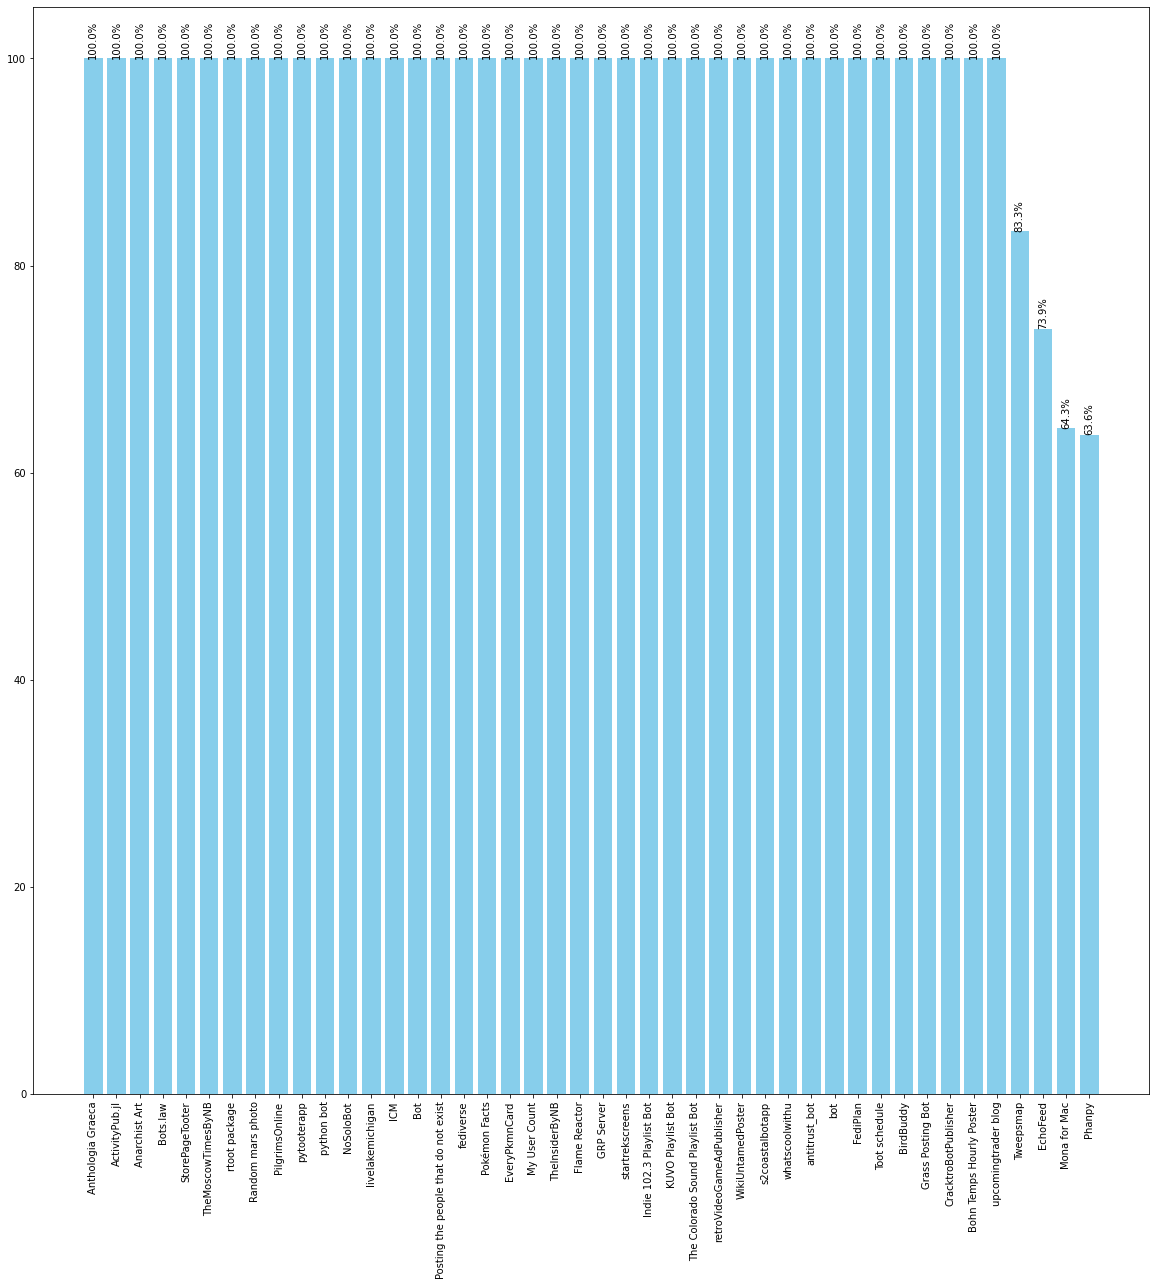

In [79]:
# Create a bar plot
plt.figure(figsize=(20, 20))
plt.bar(cl_more_post_sort_100['client'],cl_more_post_sort_100['alttext_all_percent'],color = 'skyblue')

# Add percentage values inside the bars
for i in range(len(cl_more_post_sort_100)):
    x = cl_more_post_sort_100['client'].iloc[i]  # Get the x position for the bar
    bar_height = cl_more_post_sort_100['alttext_all_percent'].iloc[i]  # Get the height of the bar
    
    # Annotate the percentage value
    plt.text(x, bar_height, f"{bar_height:.1f}%", ha='center', va='bottom', color='black', fontsize=10, rotation=90)

    
plt.xticks(rotation=90)
plt

<ipython-input-56-6fb92b25465d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cl_more_post_sort_100['label'] =cl_more_post_sort_100.apply(lambda row: f"{row['client']}\n{row['alttext_all_count']} posts\n({row['alttext_all_percent']:.1f}%)", axis=1)


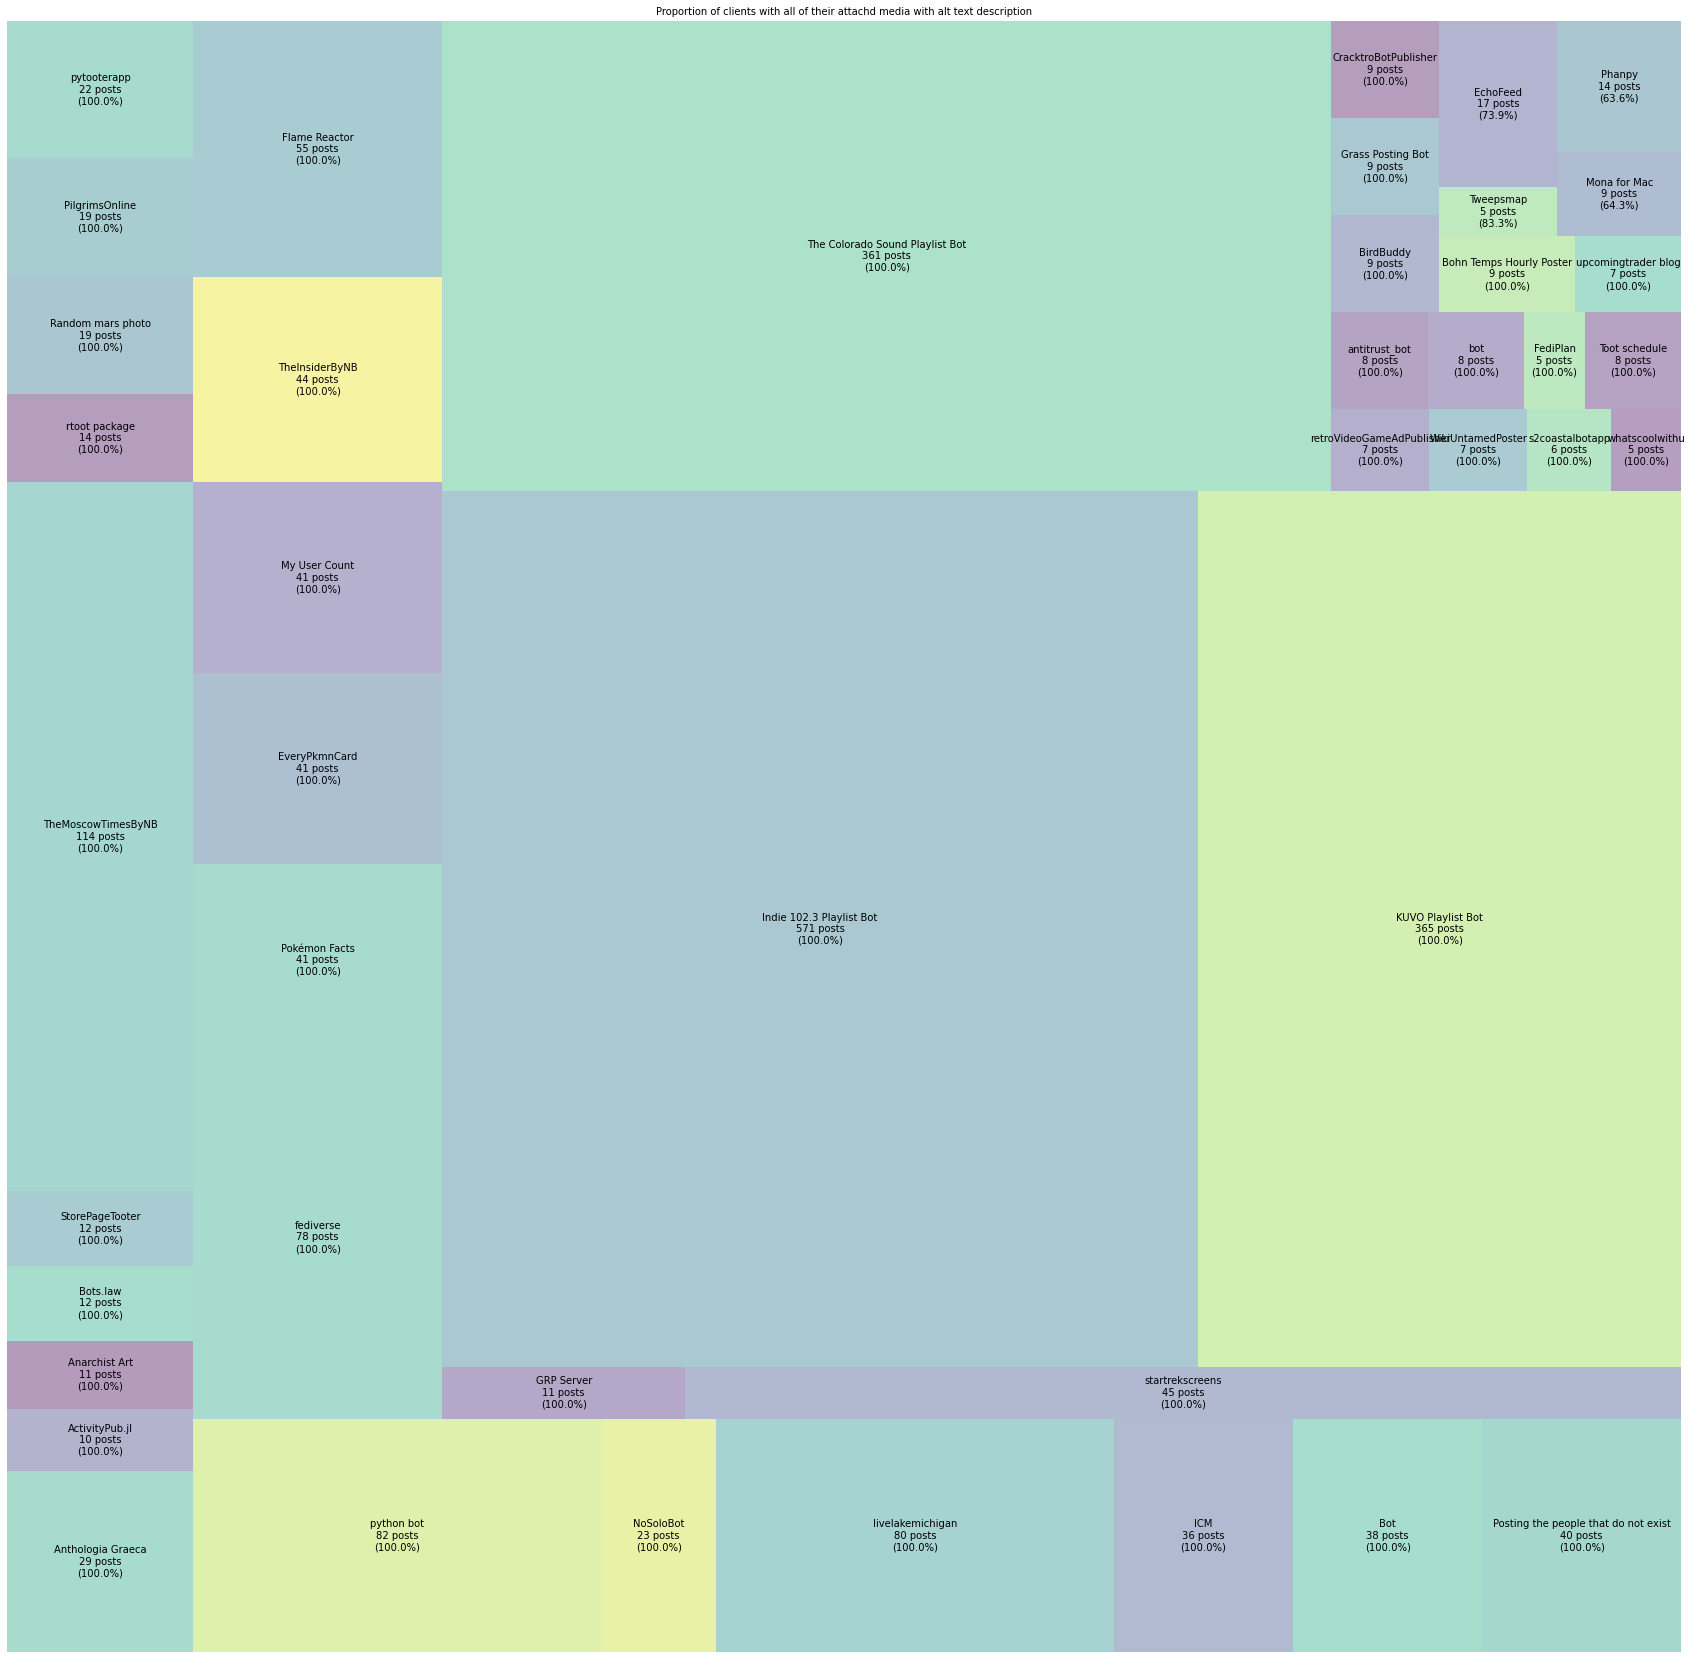

In [56]:
## visualization to see the proportions of clients on their contribution on the alt text images

#confirm percentages of alttext_all_percent
#labels
cl_more_post_sort_100['label'] =cl_more_post_sort_100.apply(lambda row: f"{row['client']}\n{row['alttext_all_count']} posts\n({row['alttext_all_percent']:.1f}%)", axis=1)
    
# Treemap plotting
plt.figure(figsize=(30, 30))
squarify.plot(sizes=cl_more_post_sort_100['alttext_all_count'], label=cl_more_post_sort_100['label'], alpha=0.4)
plt.title("Proportion of clients with all of their attachd media with alt text description", fontsize=10)
plt.axis('off')  # No axes for treemap
plt.show()

In [33]:
# best clients will be the ones that has higher number in altext count and zero y no altx text column, sort columns 

#create column with difference of alttext_all_count - alttext_none_count, the higher the difference we could say that has more alt image than the one that doesnt

cl_more_post['difference'] =   cl_more_post['alttext_none_count'] - cl_more_post['alttext_all_count']

cl_more_post_sort = cl_more_post.sort_values(by = 'difference', ascending = False)
#cl_more_post_sort = cl_more_post.sort_values(by = ['alttext_all_count','alttext_none_count'],ascending = [False,True])
cl_more_post_sort

<ipython-input-33-61639dfd46b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cl_more_post['difference'] =   cl_more_post['alttext_none_count'] - cl_more_post['alttext_all_count']


,client,posts_count,alttext_all_count,alttext_all_percent,alttext_some_count,alttext_some_percent,alttext_none_count,alttext_none_percent,difference
1,dlvr.it,5806,1,0.017224,0,0.000000,5805,99.982776,5804
0,Web,8272,1438,17.383946,7,0.084623,6827,82.531431,5389
2,Mastodon for Android,1894,270,14.255544,3,0.158395,1621,85.586061,1351
4,AboveMaidstoneBot,1339,0,0.000000,0,0.000000,1339,100.000000,1339
3,unknown,1428,366,25.630252,1,0.070028,1061,74.299720,695
...,...,...,...,...,...,...,...,...,...
35,python bot,82,82,100.000000,0,0.000000,0,0.000000,-82
28,TheMoscowTimesByNB,114,114,100.000000,0,0.000000,0,0.000000,-114
10,The Colorado Sound Playlist Bot,361,361,100.000000,0,0.000000,0,0.000000,-361
9,KUVO Playlist Bot,365,365,100.000000,0,0.000000,0,0.000000,-365


<AxesSubplot:xlabel='difference', ylabel='Count'>

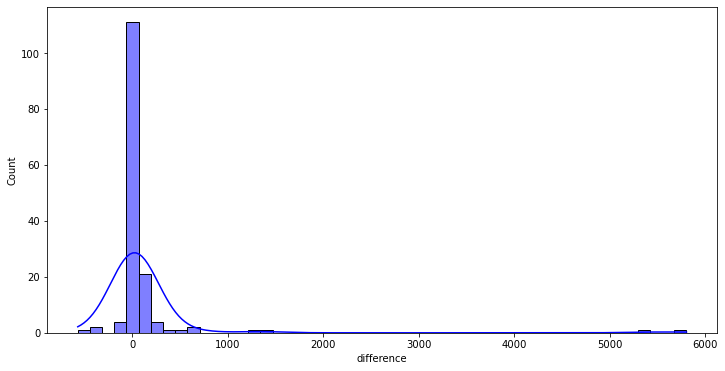

In [34]:
plt.figure(figsize=(12, 6))
sns.histplot(cl_more_post_sort['difference'], bins=50, kde=True, color='blue', edgecolor='black')